In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
from typing import Any
sys.path.insert(0, os.path.abspath('..'))

from src.feature_engineer import load_encoder
from src.utils.model_utils import evaulate_model, train_model
from src.utils.visualize_utils import plot_cm, get_avg_fold
from src.utils.math_utils import get_fft_power

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import StandardScaler

from scipy.spatial.transform import Rotation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
raw_path = "../data/raw"
encoder_path = "../models/label_encoder.pkl"

In [ ]:
# load
full_df = pd.merge(
    left=pd.read_csv(os.path.join(raw_path, "train.csv")),
    right=pd.read_csv(os.path.join(raw_path, "train_demographics.csv")),
    on="subject",
    how="left",
)

full_df = full_df.drop(columns=[col for col in full_df.columns if col.startswith("tof_")])

full_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,thm_3,thm_4,thm_5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,...,29.553024,28.592863,28.310535,0,12,1,1,163.0,52,24.0
1,SEQ_000007_000001,Target,SEQ_000007,1,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.949219,...,29.791740,28.663383,28.406172,0,12,1,1,163.0,52,24.0
2,SEQ_000007_000002,Target,SEQ_000007,2,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.722656,...,30.090014,28.796087,28.529778,0,12,1,1,163.0,52,24.0
3,SEQ_000007_000003,Target,SEQ_000007,3,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.601562,...,29.310717,29.018711,27.402010,0,12,1,1,163.0,52,24.0
4,SEQ_000007_000004,Target,SEQ_000007,4,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,5.566406,...,26.808746,29.408604,27.357603,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,27.857061,30.359417,29.501087,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,27.965866,30.417227,29.244358,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,27.893045,30.340141,29.244358,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,28.046608,30.397961,28.868093,1,30,0,1,186.0,55,30.0


In [ ]:
target_gestures = full_df[full_df["sequence_type"] == "Target"]["gesture"].unique()

filtered_df = full_df[full_df["phase"] == "Gesture"]

# feature engineer rot_w r_x, rt_y rotz
# drop na
bad_seq_id = full_df[full_df["rot_w"].isnull()]["sequence_id"].unique()
bad_seq_mask = filtered_df["sequence_id"].isin(bad_seq_id)
filtered_df = filtered_df[~bad_seq_mask]

filtered_df

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,thm_3,thm_4,thm_5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
25,SEQ_000007_000025,Target,SEQ_000007,25,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,29.079510,29.042253,28.541002,0,12,1,1,163.0,52,24.0
26,SEQ_000007_000026,Target,SEQ_000007,26,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.984375,...,29.175192,29.120226,28.313978,0,12,1,1,163.0,52,24.0
27,SEQ_000007_000027,Target,SEQ_000007,27,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,7.027344,...,29.131096,29.104778,28.361975,0,12,1,1,163.0,52,24.0
28,SEQ_000007_000028,Target,SEQ_000007,28,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.488281,...,29.123035,29.010979,28.306007,0,12,1,1,163.0,52,24.0
29,SEQ_000007_000029,Target,SEQ_000007,29,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Cheek - pinch skin,6.988281,...,29.118908,28.964226,28.489258,0,12,1,1,163.0,52,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574940,SEQ_065531_000048,Non-Target,SEQ_065531,48,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.503906,...,27.857061,30.359417,29.501087,1,30,0,1,186.0,55,30.0
574941,SEQ_065531_000049,Non-Target,SEQ_065531,49,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.773438,...,27.965866,30.417227,29.244358,1,30,0,1,186.0,55,30.0
574942,SEQ_065531_000050,Non-Target,SEQ_065531,50,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.082031,...,27.893045,30.340141,29.244358,1,30,0,1,186.0,55,30.0
574943,SEQ_065531_000051,Non-Target,SEQ_065531,51,SUBJ_039498,Seated Lean Non Dom - FACE DOWN,Performs gesture,Gesture,Write name on leg,3.964844,...,28.046608,30.397961,28.868093,1,30,0,1,186.0,55,30.0


295
unique subjects:  ['SUBJ_061552' 'SUBJ_011323' 'SUBJ_021670' 'SUBJ_054811' 'SUBJ_027682'
 'SUBJ_026824' 'SUBJ_059330' 'SUBJ_000206' 'SUBJ_038277' 'SUBJ_002923'
 'SUBJ_017499' 'SUBJ_024825' 'SUBJ_019756' 'SUBJ_047636' 'SUBJ_058967'
 'SUBJ_028998' 'SUBJ_008728' 'SUBJ_039234' 'SUBJ_044680' 'SUBJ_032585'
 'SUBJ_013623' 'SUBJ_053173' 'SUBJ_034631' 'SUBJ_064387' 'SUBJ_050642'
 'SUBJ_003328' 'SUBJ_056936' 'SUBJ_036405' 'SUBJ_024137' 'SUBJ_032165'
 'SUBJ_032761' 'SUBJ_059520' 'SUBJ_052342' 'SUBJ_058786' 'SUBJ_041770'
 'SUBJ_043192' 'SUBJ_032704' 'SUBJ_053217' 'SUBJ_020948' 'SUBJ_030676'
 'SUBJ_012088' 'SUBJ_008304' 'SUBJ_051942' 'SUBJ_032233' 'SUBJ_039498'
 'SUBJ_042254' 'SUBJ_049223' 'SUBJ_063319' 'SUBJ_040310' 'SUBJ_034574'
 'SUBJ_035353' 'SUBJ_063346' 'SUBJ_023739' 'SUBJ_019262' 'SUBJ_001430'
 'SUBJ_063447' 'SUBJ_059960' 'SUBJ_024086' 'SUBJ_040724' 'SUBJ_036450'
 'SUBJ_040106' 'SUBJ_038023' 'SUBJ_057917' 'SUBJ_041243' 'SUBJ_045235'
 'SUBJ_055211' 'SUBJ_053906' 'SUBJ_019297' 'SUBJ_017807

,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,...,thm_3,thm_4,thm_5,adult_child,age,sex,handedness,height_cm,shoulder_to_wrist_cm,elbow_to_wrist_cm
3288,SEQ_000335_000066,Target,SEQ_000335,66,SUBJ_061552,Seated Straight,Performs gesture,Gesture,Neck - scratch,0.054688,...,26.932573,28.358753,28.689663,0,11,0,0,148.0,43,25.0
3289,SEQ_000335_000067,Target,SEQ_000335,67,SUBJ_061552,Seated Straight,Performs gesture,Gesture,Neck - scratch,-0.062500,...,28.693087,28.064404,28.538034,0,11,0,0,148.0,43,25.0
3290,SEQ_000335_000068,Target,SEQ_000335,68,SUBJ_061552,Seated Straight,Performs gesture,Gesture,Neck - scratch,-0.367188,...,28.472103,28.118015,28.644592,0,11,0,0,148.0,43,25.0
3291,SEQ_000335_000069,Target,SEQ_000335,69,SUBJ_061552,Seated Straight,Performs gesture,Gesture,Neck - scratch,0.128906,...,28.104254,27.948378,28.586971,0,11,0,0,148.0,43,25.0
3292,SEQ_000335_000070,Target,SEQ_000335,70,SUBJ_061552,Seated Straight,Performs gesture,Gesture,Neck - scratch,0.359375,...,28.567001,27.962719,28.507441,0,11,0,0,148.0,43,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572809,SEQ_065329_000165,Non-Target,SEQ_065329,165,SUBJ_051942,Seated Straight,Performs gesture,Gesture,Feel around in tray and pull out an object,8.308594,...,23.268967,24.031301,23.608559,1,26,1,1,172.0,54,24.0
572810,SEQ_065329_000166,Non-Target,SEQ_065329,166,SUBJ_051942,Seated Straight,Performs gesture,Gesture,Feel around in tray and pull out an object,6.167969,...,23.210278,24.064062,23.675247,1,26,1,1,172.0,54,24.0
572811,SEQ_065329_000167,Non-Target,SEQ_065329,167,SUBJ_051942,Seated Straight,Performs gesture,Gesture,Feel around in tray and pull out an object,6.656250,...,23.210278,24.064062,23.696018,1,26,1,1,172.0,54,24.0
572812,SEQ_065329_000168,Non-Target,SEQ_065329,168,SUBJ_051942,Seated Straight,Performs gesture,Gesture,Feel around in tray and pull out an object,7.078125,...,23.231342,24.092430,23.646263,1,26,1,1,172.0,54,24.0


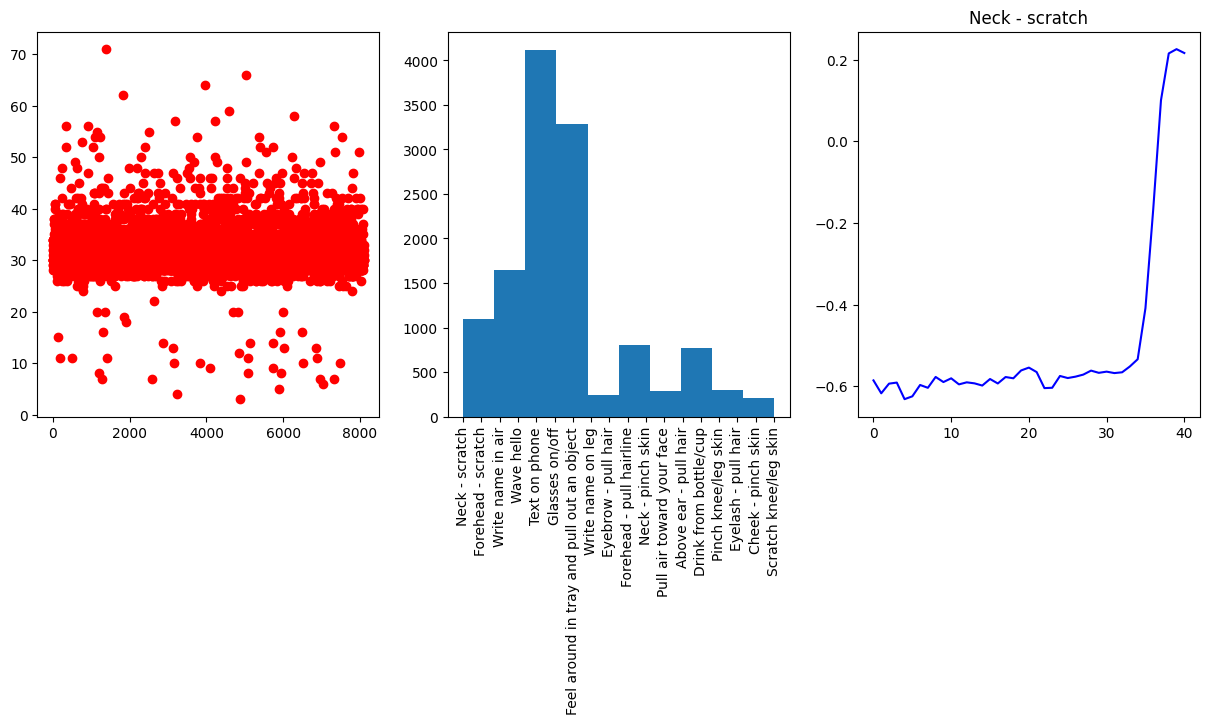

In [ ]:
gesture_length = filtered_df.groupby('sequence_id')['sequence_counter'].max() - filtered_df.groupby('sequence_id')['sequence_counter'].min() + 1

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot(np.arange(len(gesture_length)), gesture_length, 'ro')
gesture_length.max()

mask = gesture_length >= 40

weird_indices = filtered_df.groupby('sequence_id')['sequence_counter'].max()[mask].index
print(len(weird_indices))
gestures = filtered_df[filtered_df['sequence_id'].isin(weird_indices)]['gesture']
plt.subplot(132)
plt.hist(gestures)
plt.xticks(rotation=90)
weird_idx = weird_indices[0]


plt.subplot(133)
weird_seq = filtered_df[filtered_df['sequence_id'] == weird_idx]['rot_y']
plt.plot(np.arange(len(weird_seq)), weird_seq, 'b')
plt.title(filtered_df[filtered_df['sequence_id'] == weird_idx]['gesture'].unique()[0])
full_df[full_df['sequence_id'] == "SEQ_014205"]

unique_subjects = filtered_df[filtered_df['sequence_id'].isin(weird_indices)]
print('unique subjects: ', unique_subjects['subject'].unique())
unique_subjects

,sequence_id,sequence_counter,phase
125669,SEQ_014205,0,Transition
125670,SEQ_014205,1,Transition
125671,SEQ_014205,2,Transition
125672,SEQ_014205,3,Transition
125673,SEQ_014205,4,Transition
...,...,...,...
126335,SEQ_014205,666,Gesture
126336,SEQ_014205,667,Gesture
126337,SEQ_014205,668,Gesture
126338,SEQ_014205,669,Gesture


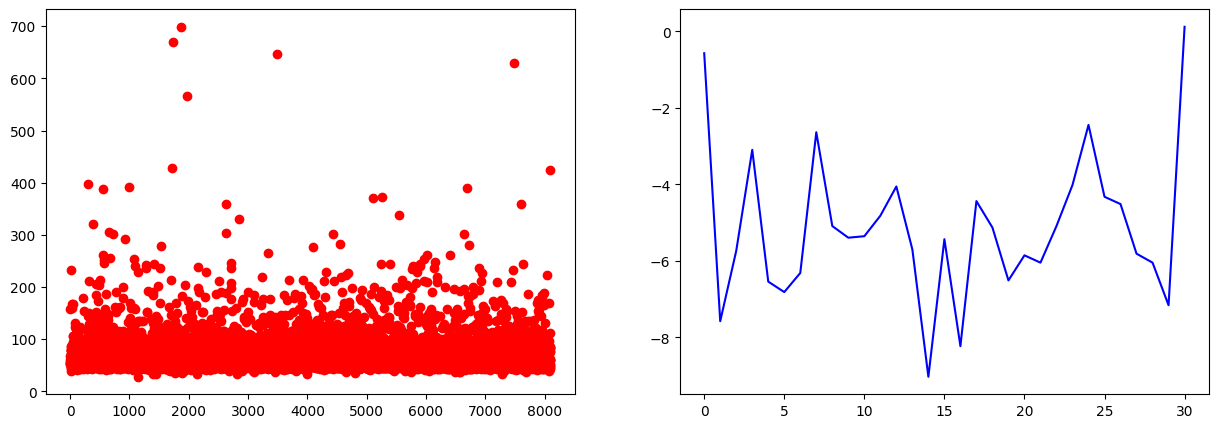

In [91]:
gesture_length = filtered_df.groupby('sequence_id')['sequence_counter'].max()

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot(np.arange(len(gesture_length)), gesture_length, 'ro')
gesture_length.max()

mask = filtered_df.groupby('sequence_id')['sequence_counter'].max() >= 500
weird_idx = filtered_df.groupby('sequence_id')['sequence_counter'].max()[mask].index

plt.subplot(122)
weird_seq = filtered_df[filtered_df['sequence_id'] == weird_idx[0]]['acc_x']
plt.plot(np.arange(len(weird_seq)), weird_seq, 'b')
full_df[full_df['sequence_id'] == "SEQ_014205"][['sequence_id', 'sequence_counter', 'phase']]

In [ ]:
There is clearly people where something went wrong during there experience that they had to shut it down early, below 6 isnt' even acceptable
